In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from astropy.io import fits

### Calculating bias

In [3]:
#function to get the data from fits files
def get_data(file):
    foo = fits.open(file)
    return foo[0].data

In [4]:
#function to calculate bias average value and standard deviation
#code credit: https://stackoverflow.com/questions/10377998/how-can-i-iterate-over-files-in-a-given-directory
def bias_calc(directory):
    averages = []
    stds = []
    for filename in os.listdir(directory):
        if filename.endswith(".fits"):
              averages.append(get_data(directory + '/' + filename).mean())
              stds.append(get_data(directory + '/' + filename).std())
    avg = np.array([averages])
    stan = np.array([stds])
    mean = avg.mean()
    std = stan.mean()
    return mean,std

In [5]:
#directories for the bias data
bias_directory_008 = 'data/darks/0.008'
bias_directory_009 = 'data/darks/0.009'

In [6]:
#biases for 0.008 s and 0.009 s exposures 
bias_008,std_008 = bias_calc(bias_directory_008)
bias_009,std_009 = bias_calc(bias_directory_009)

In [7]:
print(bias_008)
print(std_008)
print(bias_009)
print(std_009)

766.3802704883889
28.476783627343334
766.4963268640007
28.424245044490817


### Jupiter Data

In [8]:
jupiter_directory = 'data/jupiter'

In [9]:
#put all our images in a single array of arrays. Then we can access each individual image using index
def multiple_fits(directory):    
    images = []
    for filename in os.listdir(directory):
        images.append(get_data(directory + '/' + filename))
    data = np.array(images)
    return data

In [10]:
jupiter_data = multiple_fits(jupiter_directory)

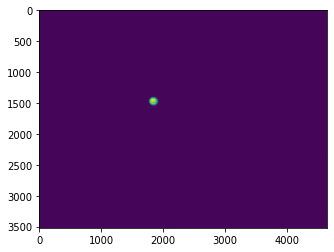

In [11]:
#the first image
plt.imshow(jupiter_data[21])

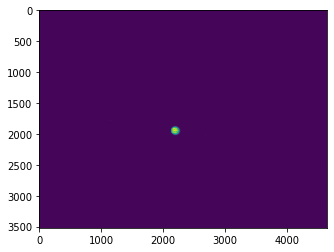

In [12]:
plt.imshow(jupiter_data[0])